In [454]:
import requests
import csv
from datetime import datetime
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import time

In [455]:
symbol = 'BTCUSDT'
interval = '1m'
limit = 1000
url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'

# Получение данных
current_time = int(time.time() * 1000)
all_data = []
for i in range(10):
    end_time = current_time - i * limit * 60 * 1000
    start_index = i * limit
    response = requests.get(f'{url}&startTime={end_time}')
    data = response.json()
    all_data.extend(data)

# Сохранение даты закрытия и цены закрытия
filtered_data = [(candle[6], candle[4]) for candle in all_data]

# Запись CSV
with open('data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Close'])
    for candle in filtered_data:
        timestamp = candle[0]
        date = datetime.fromtimestamp(timestamp/1000)
        writer.writerow([date.year, date.month, date.day, date.hour, date.minute, candle[1]])

In [456]:
df = pd.read_csv('data.csv')
df = df.replace('\s+', '', regex=True)

df = df.sort_values(by=['Day', 'Month', 'Year'], ignore_index=True)

#добавление shift чтобы регрессия основывалась на прошлых значениях цены актива
df['lag1'] = df['Close'].shift(periods=1)
df['lag2'] = df['Close'].shift(periods=2)
df['lag3'] = df['Close'].shift(periods=3)
df['lag4'] = df['Close'].shift(periods=4)
df['lag5'] = df['Close'].shift(periods=5)

df['lag1'].fillna(df['lag1'].mean(), inplace=True)
df['lag2'].fillna(df['lag2'].mean(), inplace=True)
df['lag3'].fillna(df['lag3'].mean(), inplace=True)
df['lag4'].fillna(df['lag4'].mean(), inplace=True)
df['lag5'].fillna(df['lag5'].mean(), inplace=True)

df

,Year,Month,Day,Hour,Minute,Close,lag1,lag2,lag3,lag4,lag5
0,2023,4,4,23,58,28257.80,28083.112885,28083.087175,28083.061458,28083.035736,28083.008511
1,2023,4,4,23,59,28250.04,28257.800000,28083.087175,28083.061458,28083.035736,28083.008511
2,2023,4,4,7,18,27862.37,28250.040000,28257.800000,28083.061458,28083.035736,28083.008511
3,2023,4,4,7,19,27867.74,27862.370000,28250.040000,28257.800000,28083.035736,28083.008511
4,2023,4,4,7,20,27867.75,27867.740000,27862.370000,28250.040000,28257.800000,28083.008511
...,...,...,...,...,...,...,...,...,...,...,...
8995,2023,4,10,13,13,28327.92,28329.720000,28329.630000,28325.670000,28325.680000,28319.050000
8996,2023,4,10,13,14,28314.46,28327.920000,28329.720000,28329.630000,28325.670000,28325.680000
8997,2023,4,10,13,15,28314.46,28314.460000,28327.920000,28329.720000,28329.630000,28325.670000
8998,2023,4,10,13,16,28314.45,28314.460000,28314.460000,28327.920000,28329.720000,28329.630000


In [457]:
X = df.drop('Close', axis=1)
y = df['Close']

In [458]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #разделение данных

In [459]:
X_train

,Year,Month,Day,Hour,Minute,lag1,lag2,lag3,lag4,lag5
1352,2023,4,5,22,28,28183.12,28154.98,28134.23,28150.00,28150.47
4983,2023,4,7,14,57,27834.89,27830.24,27845.18,27843.13,27834.14
8343,2023,4,10,2,21,28370.39,28370.45,28368.53,28368.54,28369.55
5553,2023,4,8,15,9,27995.53,28005.48,28006.14,28006.95,28007.71
5031,2023,4,7,15,45,27924.03,27918.25,27897.98,27860.73,27862.80
...,...,...,...,...,...,...,...,...,...,...
8324,2023,4,10,2,2,28376.66,28397.19,28371.39,28366.23,28370.47
4161,2023,4,7,23,17,27904.87,27906.36,27906.37,27906.37,27907.10
7243,2023,4,9,8,37,28057.75,28057.75,28057.74,28058.71,28060.43
2946,2023,4,6,17,42,27920.14,27927.98,27924.13,27923.10,27922.76


In [460]:
X_test

,Year,Month,Day,Hour,Minute,lag1,lag2,lag3,lag4,lag5
3954,2023,4,7,19,50,27877.64,27876.88,27873.64,27882.01,27882.00
5959,2023,4,8,21,55,27901.55,27894.59,27896.49,27878.96,27909.63
1848,2023,4,5,6,44,28510.98,28515.47,28489.61,28500.00,28490.67
7906,2023,4,9,19,40,27927.44,27927.44,27928.84,27917.17,27928.98
8976,2023,4,10,12,54,28307.24,28307.24,28305.47,28314.28,28314.27
...,...,...,...,...,...,...,...,...,...,...
1729,2023,4,5,4,45,28588.43,28605.24,28645.61,28652.08,28645.09
1649,2023,4,5,3,25,28269.34,28200.15,28193.86,28162.30,28149.60
7588,2023,4,9,14,22,27873.56,27879.76,27881.33,27881.32,27881.33
1576,2023,4,5,2,12,28161.28,28166.00,28167.14,28175.21,28183.09


In [461]:
y_train

1352    28185.34
4983    27835.64
8343    28379.51
5553    27995.51
5031    27930.13
          ...   
8324    28368.07
4161    27922.99
7243    28057.74
2946    27925.41
3074    28122.90
Name: Close, Length: 6300, dtype: float64

In [464]:
model = Sequential()

model.add(LSTM(11, input_shape=[None, 1], activation="selu", return_sequences=False))


model.add(Dense(1))

model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, batch_size = 30, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
210/210 [==============================] - 2s 5ms/step - loss: 382960192.0000 - val_loss: 47863532.0000
Epoch 2/10
210/210 [==============================] - 1s 3ms/step - loss: 8581696.0000 - val_loss: 65203.5898
Epoch 3/10
210/210 [==============================] - 1s 3ms/step - loss: 6072.5518 - val_loss: 658.8595
Epoch 4/10
210/210 [==============================] - 1s 3ms/step - loss: 651.3463 - val_loss: 658.6742
Epoch 5/10
210/210 [==============================] - 1s 3ms/step - loss: 651.0185 - val_loss: 660.2911
Epoch 6/10
210/210 [==============================] - 1s 3ms/step - loss: 651.6497 - val_loss: 658.1948
Epoch 7/10
210/210 [==============================] - 1s 3ms/step - loss: 651.9639 - val_loss: 661.3960
Epoch 8/10
210/210 [==============================] - 1s 3ms/step - loss: 651.8136 - val_loss: 658.2516
Epoch 9/10
210/210 [==============================] - 1s 3ms/step - loss: 651.6864 - val_loss: 664.2152
Epoch 10/10
210/210 [=========================

In [465]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: ", mae)


85/85 [==============================] - 0s 2ms/step
R-squared: 0.9826790829260077
Mean Squared Error: 662.3524173357255
Mean Absolute Error:  15.484293750000038


In [466]:
y_pred

array([[27879.508],
       [27897.775],
       [28493.51 ],
       ...,
       [27880.06 ],
       [28175.283],
       [28219.479]], dtype=float32)

In [467]:
last = df.iloc[-1]
data = {'Year': int(last['Year']), 'Month': int(last['Month']), 'Day': int(last['Day']), 'Hour': int(last['Hour']), 'Minute': int(last['Minute']), 'Close': last['Close'], 'lag1': last['lag1'], 'lag2': last['lag2'], 'lag3': last['lag3'], 'lag4': last['lag4'], 'lag5': last['lag5']}
date_time = datetime(int(last['Year']), int(last['Month']), int(last['Day']), int(last['Hour']), int(last['Minute']))
new_df = pd.DataFrame(data, index=[0])
for i in range(1, 61):
    date_time_new = date_time + timedelta(minutes=i)
    date_object = datetime.strptime(str(date_time_new), "%Y-%m-%d %H:%M:%S")

    pred = model.predict(new_df.loc[[i - 1]], verbose=0)

    data = {
        'Year': int(date_object.year), 
            'Month': int(date_object.month), 
            'Day': int(date_object.day), 
            'Hour': int(date_object.hour), 
            'Minute': int(date_object.minute), 
            'Close': pred[0][0], 
            'lag1': new_df.loc[i-1, 'Close'], 
            'lag2': new_df.loc[i-1, 'lag1'], 
            'lag3': new_df.loc[i-1, 'lag2'], 
            'lag4': new_df.loc[i-1, 'lag3'],
            'lag5': new_df.loc[i-1, 'lag4']
            }
    
    new_df = new_df.append(data, ignore_index=True)
new_df

C:\Users\ReyLegar\AppData\Local\Temp\ipykernel_18428\1693002174.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(data, ignore_index=True)
C:\Users\ReyLegar\AppData\Local\Temp\ipykernel_18428\1693002174.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(data, ignore_index=True)
C:\Users\ReyLegar\AppData\Local\Temp\ipykernel_18428\1693002174.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(data, ignore_index=True)
C:\Users\ReyLegar\AppData\Local\Temp\ipykernel_18428\1693002174.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(data, ign

,Year,Month,Day,Hour,Minute,Close,lag1,lag2,lag3,lag4,lag5
0,2023.0,4.0,10.0,13.0,17.0,28303.540000,28314.450000,28314.460000,28314.460000,28327.920000,28329.720000
1,2023.0,4.0,10.0,13.0,18.0,28913.166016,28303.540000,28314.450000,28314.460000,28314.460000,28327.920000
2,2023.0,4.0,10.0,13.0,19.0,28921.609375,28913.166016,28303.540000,28314.450000,28314.460000,28314.460000
3,2023.0,4.0,10.0,13.0,20.0,28938.667969,28921.609375,28913.166016,28303.540000,28314.450000,28314.460000
4,2023.0,4.0,10.0,13.0,21.0,28982.777344,28938.667969,28921.609375,28913.166016,28303.540000,28314.450000
...,...,...,...,...,...,...,...,...,...,...,...
56,2023.0,4.0,10.0,14.0,13.0,35917.390625,35771.164062,35626.207031,35482.324219,35338.707031,35194.699219
57,2023.0,4.0,10.0,14.0,14.0,36064.312500,35917.390625,35771.164062,35626.207031,35482.324219,35338.707031
58,2023.0,4.0,10.0,14.0,15.0,36211.261719,36064.312500,35917.390625,35771.164062,35626.207031,35482.324219
59,2023.0,4.0,10.0,14.0,16.0,36358.351562,36211.261719,36064.312500,35917.390625,35771.164062,35626.207031


In [468]:
close = new_df['Close'].to_list()
close

[28303.54,
 28913.166015625,
 28921.609375,
 28938.66796875,
 28982.77734375,
 29065.29296875,
 29220.921875,
 29536.41796875,
 29570.046875,
 29625.712890625,
 29715.46484375,
 29845.427734375,
 30017.62109375,
 30205.111328125,
 30268.603515625,
 30358.169921875,
 30477.291015625,
 30621.650390625,
 30777.513671875,
 30916.376953125,
 31006.603515625,
 31119.775390625,
 31252.841796875,
 31396.744140625,
 31538.099609375,
 31663.654296875,
 31774.0859375,
 31901.244140625,
 32039.232421875,
 32179.560546875,
 32314.267578125,
 32440.3671875,
 32564.494140625,
 32699.150390625,
 32838.5,
 32976.78515625,
 33110.7734375,
 33241.6484375,
 33374.5546875,
 33513.3125,
 33653.51171875,
 33792.08203125,
 33928.46484375,
 34064.62109375,
 34203.17578125,
 34344.72265625,
 34486.41015625,
 34627.01171875,
 34767.00390625,
 34907.8515625,
 35050.58203125,
 35194.69921875,
 35338.70703125,
 35482.32421875,
 35626.20703125,
 35771.1640625,
 35917.390625,
 36064.3125,
 36211.26171875,
 36358.3515

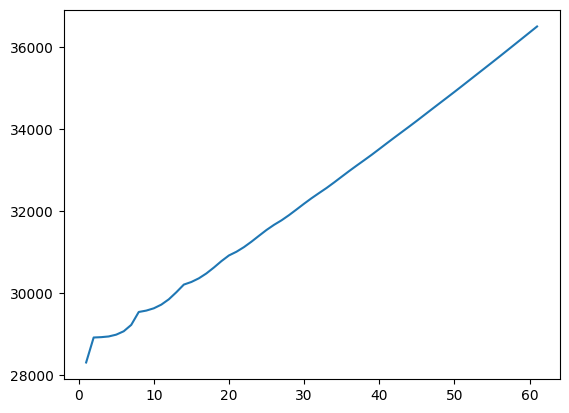

In [469]:
import matplotlib.pyplot as plt

minute_list = [i + 1 for i in range(len(close))]

plt.plot(minute_list, close)
plt.show()